In [76]:
import os

import cv2
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image
import matplotlib.pyplot as plt

In [77]:
if torch.cuda.is_available():
    print("CUDA is available. Listing GPUs:")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available.")

    # Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

CUDA is available. Listing GPUs:
GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU


In [78]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.classes = ['car', 'dog', 'person', 'bicycle']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, "Annotations"))))
        self.valid_indices = self._filter_valid_indices()

    def _filter_valid_indices(self):
        valid_indices = []
        for idx in range(len(self.images)):
            annotation_path = os.path.join(self.root, "Annotations", self.annotations[idx])
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            boxes = []
            for obj in root.iter("object"):
                xmin = int(obj.find("bndbox").find("xmin").text)
                ymin = int(obj.find("bndbox").find("ymin").text)
                xmax = int(obj.find("bndbox").find("xmax").text)
                ymax = int(obj.find("bndbox").find("ymax").text)
                if xmin < xmax and ymin < ymax:
                    boxes.append([xmin, ymin, xmax, ymax])
            if len(boxes) > 0:
                valid_indices.append(idx)
        return valid_indices

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        img_path = os.path.join(self.root, "JPEGImages", self.images[actual_idx])
        annotation_path = os.path.join(self.root, "Annotations", self.annotations[actual_idx])
        
        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        boxes = []
        labels = []
        for obj in root.iter("object"):
            label = self.class_to_idx[obj.find("name").text]
            xmin = int(obj.find("bndbox").find("xmin").text)
            ymin = int(obj.find("bndbox").find("ymin").text)
            xmax = int(obj.find("bndbox").find("xmax").text)
            ymax = int(obj.find("bndbox").find("ymax").text)
            if xmin < xmax and ymin < ymax:
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(label)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms:
            img, target = self.transforms(img, target)
        
        return img, target

    def __len__(self):
        return len(self.valid_indices)

class RandomNoise:
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, image):
        noise = torch.randn(image.size()) * self.std + self.mean
        image = image + noise
        image = torch.clamp(image, 0, 1)  # Ensure the pixel values are still between 0 and 1
        return image

class HorizontalFlip:
    def __call__(self, image, target):
        image = torch.flip(image, [2])
        width = image.shape[2]

        boxes = target["boxes"]
        boxes = boxes.clone()

        xmin = width - boxes[:, 2]
        xmax = width - boxes[:, 0]
        boxes[:, 0] = xmin
        boxes[:, 2] = xmax

        target["boxes"] = boxes

        return image, target

class ComposeWithTarget:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            if isinstance(t, HorizontalFlip):
                image, target = t(image, target)
            else:
                image = t(image)
        return image, target

# Updated get_transform function with noise addition and horizontal flip
def get_transform(train):
    if train:
        return ComposeWithTarget([
            T.ToTensor(),
            HorizontalFlip(),
            RandomNoise(mean=0.0, std=0.05),
        ])
    else:
        return ComposeWithTarget([
            T.ToTensor(),
        ])

# Collate function
def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None and b[1] is not None]
    if len(batch) == 0:
        return [], []
    return tuple(zip(*batch))


In [79]:
model = fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
num_classes = 4  # 4 classes including background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [80]:
model.to(device)
dataset = VOCDataset(root='Flir_ADAS.v2i.voc/train', transforms=get_transform(train=True))
data_loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)


In [81]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.5, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


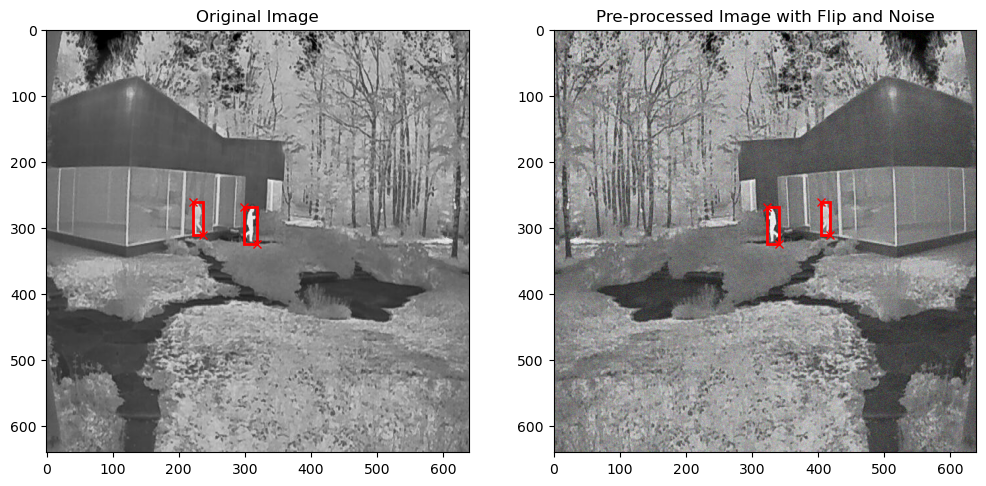

In [82]:
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import Image
import xml.etree.ElementTree as ET
import os
# 
# class RandomNoise:
#     def __init__(self, mean=0.0, std=0.1):
#         self.mean = mean
#         self.std = std
# 
#     def __call__(self, image):
#         noise = torch.randn(image.size()) * self.std + self.mean
#         image = image + noise
#         image = torch.clamp(image, 0, 1)  # Ensure the pixel values are still between 0 and 1
#         return image
# 
# # Updated get_transform function with noise addition
# def get_transform(train):
#     if train:
#         return T.Compose([
#             T.ToTensor(),
#             RandomNoise(mean=0.0, std=0.05),
#         ])
#     else:
#         return T.ToTensor()
# 
# # Collate function
# def collate_fn(batch):
#     batch = [b for b in batch if b[0] is not None and b[1] is not None]
#     if len(batch) == 0:
#         return [], []
#     return tuple(zip(*batch))
from PIL import ImageDraw


# # Utility function to display images
# def show_image_with_boxes(img, target, title):
#     img = T.ToPILImage()(img)
#     draw = ImageDraw.Draw(img)
#     for box in target["boxes"]:
#         draw.rectangle(box.tolist(), outline="red", width=2)
#     plt.imshow(img)
#     plt.title(title)
#     plt.axis('off')
    



def show_image_with_boxes(image, target, title):
    plt.imshow(image.permute(1, 2, 0))
    ax = plt.gca()
    for box in target['boxes']:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.plot(xmin, ymin, 'rx')  # top-left corner
        ax.plot(xmax, ymax, 'rx')  # bottom-right corner
    plt.title(title)


classes = ['car', 'dog', 'person', 'bicycle']
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
def og(img_path, annotation_path):
    img = Image.open(img_path).convert("RGB")
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    
    boxes = []
    labels = []
    for obj in root.iter("object"):
        label = class_to_idx[obj.find("name").text]
        xmin = int(obj.find("bndbox").find("xmin").text)
        ymin = int(obj.find("bndbox").find("ymin").text)
        xmax = int(obj.find("bndbox").find("xmax").text)
        ymax = int(obj.find("bndbox").find("ymax").text)
        if xmin < xmax and ymin < ymax:
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)
    
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    return img, target
# Fetch and display a sample

# Get the original image and target without transformations
original_img_path = os.path.join('Flir_ADAS.v2i.voc/train', "JPEGImages", dataset.images[dataset.valid_indices[0]])
original_annotation_path = os.path.join('Flir_ADAS.v2i.voc/train', "Annotations", dataset.annotations[dataset.valid_indices[0]])
original_img, original_boxes = og(original_img_path, original_annotation_path)
original_img = T.ToTensor()(original_img)

img, target = dataset[0]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
show_image_with_boxes(original_img, original_boxes, "Original Image")

plt.subplot(1, 2, 2)
show_image_with_boxes(img, target, "Pre-processed Image with Flip and Noise")

plt.show()


In [46]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        if len(images) == 0:  # Skip if no valid images in the batch
            continue
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {losses.item()}")

    # Update learning rate
    lr_scheduler.step()

KeyboardInterrupt: 

In [26]:
# Load the saved model weights
model.load_state_dict(torch.load("faster_rcnn_model.pth", map_location=device))
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [27]:
# Set model to evaluation mode and make predictions
model.eval()
img, _ = dataset[0]

# Move the input image to the same device as the model
img = img.to(device)

prediction = model([img])
print(prediction)

[{'boxes': tensor([[3.9164e+00, 1.8141e+01, 1.5535e+02, 4.8265e+02],
        [3.5425e+02, 3.6307e+02, 4.4640e+02, 3.8830e+02],
        [4.6483e+02, 3.5501e+02, 4.8224e+02, 3.6765e+02],
        [3.7911e+02, 3.6827e+02, 4.4169e+02, 3.8637e+02],
        [1.9586e+02, 2.7651e+02, 2.7803e+02, 3.1146e+02],
        [1.0337e+02, 5.4402e+02, 1.6932e+02, 6.3834e+02],
        [3.3666e+02, 3.5829e+02, 4.6021e+02, 3.8182e+02],
        [0.0000e+00, 4.5400e+02, 2.7067e+02, 6.4000e+02],
        [1.5106e+02, 4.2699e+02, 3.8422e+02, 6.2559e+02],
        [7.2718e+01, 5.1888e+02, 1.6373e+02, 6.3624e+02],
        [2.7255e+02, 3.0869e+02, 3.0232e+02, 3.2353e+02],
        [4.6797e+01, 1.7385e+00, 4.8318e+02, 1.2649e+02],
        [3.8278e+02, 4.0362e+02, 4.6908e+02, 4.4258e+02],
        [3.7168e+02, 9.9566e+01, 5.1270e+02, 4.2749e+02],
        [1.1861e+02, 4.5829e+02, 2.5842e+02, 6.3120e+02],
        [4.6689e+02, 1.0335e+02, 5.1263e+02, 3.1907e+02],
        [4.4687e+01, 5.6013e+02, 1.9413e+02, 6.3559e+02],
   

In [28]:

# Load the test dataset
test_dataset = VOCDataset(root='Flir_ADAS.v2i.voc/test', transforms=get_transform(train=False))
test_data_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)


In [29]:

# Set model to evaluation mode
model.eval()

def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) of two bounding boxes."""
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    xi1 = max(x1, x1_)
    yi1 = max(y1, y1_)
    xi2 = min(x2, x2_)
    yi2 = min(y2, y2_)
    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2_ - x1_ + 1) * (y2_ - y1_ + 1)

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area

    return iou

iou_threshold = 0.5

all_labels = []
all_predictions = []

for images, targets in test_data_loader:
    images = [img.to(device) for img in images]
    outputs = model(images)

    for target, output in zip(targets, outputs):
        true_boxes = target['boxes'].cpu().numpy()
        true_labels = target['labels'].cpu().numpy()
        
        pred_boxes = output['boxes'].detach().cpu().numpy()
        pred_scores = output['scores'].detach().cpu().numpy()
        pred_labels = output['labels'].detach().cpu().numpy()

        for label in range(num_classes):
            true_mask = (true_labels == label)
            pred_mask = (pred_labels == label) & (pred_scores >= 0.5)
            
            all_labels.append(true_mask.sum())
            all_predictions.append(pred_mask.sum())

precision = np.sum(all_predictions) / (np.sum(all_predictions) + np.sum(all_labels))
recall = np.sum(all_predictions) / (np.sum(all_labels))

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

def calculate_ap_from_precision_recall(precision, recall):
    # Compute Average Precision (AP) from precision-recall data points
    # Using 11-point interpolated precision-recall curve method
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # Compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # Compute Average Precision (AP) as the area under the curve
    indices = np.where(mrec[1:] != mrec[:-1])[0] + 1
    ap = np.sum((mrec[indices] - mrec[indices - 1]) * mpre[indices])
    return ap

Precision: 0.1123
Recall: 0.1266


In [30]:

def calculate_map(true_boxes, pred_boxes, iou_threshold=0.5):
    average_precisions = []

    for label in range(len(true_boxes)):  # Iterate over each class
        true_boxes_label = true_boxes[label]
        pred_boxes_label = pred_boxes[label]
        print(pred_boxes_label)

        # Sort predictions by confidence (descending order)
        pred_boxes_label = np.array(sorted(pred_boxes_label, key=lambda x: x[4], reverse=True))

        # Initialize arrays to track true positives and false positives
        tp = np.zeros(len(pred_boxes_label))
        fp = np.zeros(len(pred_boxes_label))

        # Total number of true objects in this class
        num_true_boxes = len(true_boxes_label)

        # Loop over predicted boxes and calculate TP and FP
        for i, pred_box in enumerate(pred_boxes_label):
            if len(pred_box) < 5:
                continue  # Skip if prediction box doesn't have at least 5 elements (not enough confidence)
            
            # Extract coordinates and score from the prediction
            pred_bbox = pred_box[:4]
            pred_score = pred_box[4]

            # Initialize variables to track best IoU and matching true box
            best_iou = 0.0
            best_match = -1

            # Loop over true boxes to calculate IoU
            for j, true_box in enumerate(true_boxes_label):
                iou = calculate_iou(pred_bbox, true_box)
                if iou > best_iou:
                    best_iou = iou
                    best_match = j

            # Assign detection as true positive or false positive
            if best_iou >= iou_threshold and best_match != -1:
                if tp[best_match] == 0:
                    tp[i] = 1  # TP: first detection of this true box
                    true_boxes_label = np.delete(true_boxes_label, best_match, axis=0)  # Remove matched true box
                else:
                    fp[i] = 1  # FP: multiple detections of the same true box
            else:
                fp[i] = 1  # FP: no true box or IoU < threshold

        # Compute precision and recall from cumulative sums of TP and FP
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        precision = tp_cumsum / (tp_cumsum + fp_cumsum)
        recall = tp_cumsum / num_true_boxes

        # Compute Average Precision (AP) using the 11-point interpolated precision-recall curve
        ap = calculate_ap_from_precision_recall(precision, recall)
        average_precisions.append(ap)

    # Compute mean Average Precision (mAP) across all classes
    map_value = np.mean(average_precisions)
    return map_value


In [31]:
import numpy as np

def calculate_map(true_boxes, pred_boxes, iou_threshold=0.5):
    average_precisions = []

    for label in range(len(true_boxes)):  # Iterate over each class
        true_boxes_label = true_boxes[label]
        pred_boxes_label = pred_boxes[label]

        if len(pred_boxes_label) == 0:
            continue

        # Sort predictions by confidence (descending order)
        pred_boxes_label = np.array(sorted(pred_boxes_label, key=lambda x: x[4], reverse=True))

        # Initialize arrays to track true positives and false positives
        tp = np.zeros(len(pred_boxes_label))
        fp = np.zeros(len(pred_boxes_label))

        # Total number of true objects in this class
        num_true_boxes = len(true_boxes_label)

        # Loop over predicted boxes and calculate TP and FP
        for i, pred_box in enumerate(pred_boxes_label):
            if len(pred_box) < 5:
                continue  # Skip if prediction box doesn't have at least 5 elements (not enough confidence)
            
            # Extract coordinates and score from the prediction
            pred_bbox = pred_box[:4]
            pred_score = pred_box[4]

            # Initialize variables to track best IoU and matching true box
            best_iou = 0.0
            best_match = -1

            # Loop over true boxes to calculate IoU
            for j, true_box in enumerate(true_boxes_label):
                iou = calculate_iou(pred_bbox, true_box)
                if iou > best_iou:
                    best_iou = iou
                    best_match = j

            # Assign detection as true positive or false positive
            if best_iou >= iou_threshold and best_match != -1:
                if tp[best_match] == 0:
                    tp[i] = 1  # TP: first detection of this true box
                    true_boxes_label = np.delete(true_boxes_label, best_match, axis=0)  # Remove matched true box
                else:
                    fp[i] = 1  # FP: multiple detections of the same true box
            else:
                fp[i] = 1  # FP: no true box or IoU < threshold

        # Compute precision and recall from cumulative sums of TP and FP
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        precision = tp_cumsum / (tp_cumsum + fp_cumsum)
        recall = tp_cumsum / num_true_boxes

        # Compute Average Precision (AP) using the 11-point interpolated precision-recall curve
        ap = calculate_ap_from_precision_recall(precision, recall)
        average_precisions.append(ap)

    # Compute mean Average Precision (mAP) across all classes
    map_value = np.mean(average_precisions)
    return map_value

def calculate_iou(box1, box2):
    """Calculates the Intersection over Union (IoU) of two bounding boxes."""
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    # Calculate intersection
    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)
    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    # Calculate union
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou = inter_area / union_area
    return iou

def calculate_ap_from_precision_recall(precision, recall):
    """Calculates the Average Precision (AP) from precision and recall."""
    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([0.0], precision, [0.0]))

    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])

    indices = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])
    return ap




IndexError: index 330 is out of bounds for axis 0 with size 146

In [36]:
import numpy as np

def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_, y1_, x2_, y2_ = box2

    xi1 = max(x1, x1_)
    yi1 = max(y1, y1_)
    xi2 = min(x2, x2_)
    yi2 = min(y2, y2_)
    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)

    box1_area = (x2 - x1 + 1) * (y2 - y1 + 1)
    box2_area = (x2_ - x1_ + 1) * (y2_ - y1_ + 1)

    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area

    return iou

def calculate_map(true_boxes, pred_boxes, iou_threshold=0.5):
    average_precisions = []

    for label in range(len(true_boxes)):
        true_boxes_label = true_boxes[label]
        pred_boxes_label = pred_boxes[label]

        if len(pred_boxes_label) == 0:
            continue

        pred_boxes_label = np.array(sorted(pred_boxes_label, key=lambda x: x[4], reverse=True))

        tp = np.zeros(len(pred_boxes_label))
        fp = np.zeros(len(pred_boxes_label))

        num_true_boxes = len(true_boxes_label)

        for i, pred_box in enumerate(pred_boxes_label):
            if len(pred_box) < 5:
                continue

            pred_bbox = pred_box[:4]
            pred_score = pred_box[4]

            best_iou = 0.0
            best_match = -1

            for j, true_box in enumerate(true_boxes_label):
                iou = calculate_iou(pred_bbox, true_box)
                if iou > best_iou:
                    best_iou = iou
                    best_match = j

            if best_iou >= iou_threshold and best_match != -1:
                if len(true_boxes_label) > best_match:  # Check if best_match is within bounds
                    tp[i] = 1
                    true_boxes_label.pop(best_match)  # Remove matched true box
                else:
                    fp[i] = 1
            else:
                fp[i] = 1

        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        precision = tp_cumsum / (tp_cumsum + fp_cumsum)
        recall = tp_cumsum / num_true_boxes

        ap = calculate_ap_from_precision_recall(precision, recall)
        average_precisions.append(ap)

    map_value = np.mean(average_precisions)
    return map_value

def calculate_ap_from_precision_recall(precision, recall):
    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([0.0], precision, [0.0]))

    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = np.maximum(precision[i - 1], precision[i])

    indices = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[indices + 1] - recall[indices]) * precision[indices + 1])
    return ap

# Assuming true_boxes and pred_boxes are already defined
iou_threshold = 0.5
map_value = calculate_map(true_boxes, pred_boxes, iou_threshold)
print(f"mAP: {map_value:.4f}")


mAP: 0.0000


In [38]:
true_boxes = [[] for _ in range(num_classes)]
pred_boxes = [[] for _ in range(num_classes)]

for images, targets in test_data_loader:
    images = [img.to(device) for img in images]
    outputs = model(images)

    for target, output in zip(targets, outputs):
        for label in range(num_classes):
            true_mask = target['labels'].cpu().numpy() == label
            pred_mask = (output['labels'].detach().cpu().numpy() == label) & (output['scores'].detach().cpu().numpy() >= 0.5)
            
            true_boxes[label].extend(target['boxes'][true_mask].cpu().numpy())
            pred_boxes_with_scores = [np.append(output['boxes'][i].detach().cpu().numpy(), output['scores'][i].detach().cpu().numpy()) for i in np.where(pred_mask)[0]]
            pred_boxes[label].extend(pred_boxes_with_scores)

    map_value = calculate_map(true_boxes, pred_boxes, iou_threshold)
    print(f"mAP: {map_value:.4f}")


C:\Users\ragha\AppData\Local\Temp\ipykernel_6460\1356036360.py:66: RuntimeWarning: invalid value encountered in divide
  recall = tp_cumsum / num_true_boxes


mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: nan
mAP: 0.0417
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0008
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: 0.0000
mAP: